In [1]:
!pip3 install conllu

### Dataset Extraction

In [43]:
import conllu


# Parse the data using the CoNLL-U format parser
train_data = conllu.parse(
    open("./Dataset/en_atis-ud-train.conllu", "r", encoding="utf-8").read())
valid_data = conllu.parse(
    open("./Dataset/en_atis-ud-dev.conllu", "r", encoding="utf-8").read())
test_data = conllu.parse(
    open("./Dataset/en_atis-ud-test.conllu", "r", encoding="utf-8").read())


train_data = [[(word['form'], word['upostag'])
               for word in sentence] for sentence in train_data]
valid_data = [[(word['form'], word['upostag'])
               for word in sentence] for sentence in valid_data]
test_data = [[(word['form'], word['upostag'])
              for word in sentence] for sentence in test_data]


# Glove Embeddings

In [1]:
import numpy as np
import torch


def load_glove_embeddings(file_path):
    with open(file_path, 'r') as f:
        embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


embeddings = load_glove_embeddings('./glove.6B/glove.6B.100d.txt')
embeddings_list = [embeddings[word] for word in embeddings]
embeddings_matrix = np.array(embeddings_list)
# Add a row of zeros for the padding token
embeddings_matrix = np.vstack((np.zeros(100).astype(np.float32), embeddings_matrix))
# add for UNK 
embeddins_matrix = np.vstack((embeddings_matrix, np.random.rand(100).astype(np.float32)))

np.save('embeddings_matrix.npy', embeddings_matrix)

/home/abhishek/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PreProcessing 

In [117]:
def dictWCT(data):
    wordCount = {}
    tagCount = {}
    wordFreq = {}
    for sentence in data:
        for word in sentence:
            if word[0] not in wordCount:
                wordCount[word[0]] = len(wordCount)+1
                wordFreq[word[0]] = 1
            else:
                wordFreq[word[0]]+=1
            if word[1] not in tagCount:
                tagCount[word[1]] = len(tagCount)+1
    return wordCount, tagCount, wordFreq


wordToIdx, tagToIdx, wordFreq = dictWCT(train_data)

wordToIdx['<PAD>'] = 0
wordFreq = {k: v for k, v in wordFreq.items() if v > 2}
wordToIdx['<UNK>'] = len(wordFreq)+1
tagToIdx['<UNK>'] = len(tagToIdx)+1
numUniqueWords = len(wordFreq)
numUniqueTags = len(tagToIdx)+1
idxToWord = {v: k for k, v in wordToIdx.items()}
idxToTag = {v: k for k, v in tagToIdx.items()}

print("Number of unique words: ", numUniqueWords)
print("Number of unique tags: ", numUniqueTags)

Number of unique words:  512
Number of unique tags:  15


In [118]:
print(tagToIdx)

{'PRON': 1, 'AUX': 2, 'DET': 3, 'NOUN': 4, 'ADP': 5, 'PROPN': 6, 'VERB': 7, 'NUM': 8, 'ADJ': 9, 'CCONJ': 10, 'ADV': 11, 'PART': 12, 'INTJ': 13, '<UNK>': 14}


In [119]:
import numpy as np

def getIndices(data, wordToIdx, tagToIdx, wordFreq, min_freq=2):
    wordIndices = []
    tagIndices = []
    mxTagForUnk = {}
    for sentence in data:
        wordIdx = []
        tagIdx = []
        for word in sentence:
            if word[0] not in wordFreq:
                wordIdx.append(wordToIdx['<UNK>'])
                tagIdx.append(tagToIdx['<UNK>'])
                if word[1] not in mxTagForUnk:
                    mxTagForUnk[word[1]] = 1
                else:
                    mxTagForUnk[word[1]] += 1
            else:
                wordIdx.append(wordToIdx[word[0]])
                tagIdx.append(tagToIdx[word[1]])
        wordIndices.append(wordIdx)
        tagIndices.append(tagIdx)

    mxTagForUnk = max(mxTagForUnk, key=mxTagForUnk.get)
    # tagIndices = [[tagToIdx[mxTagForUnk] if word == wordToIdx['<UNK>'] else tag for word, tag in zip(wordIndices[i], tagIndices[i])] for i in range(len(wordIndices))]
    return wordIndices, tagIndices

wordIndices, tagIndices = getIndices(train_data, wordToIdx, tagToIdx, wordFreq)
wordIndicesValid, tagIndicesValid= getIndices(valid_data, wordToIdx, tagToIdx, wordFreq)
wordIndicesTest, tagIndicesTest = getIndices(test_data, wordToIdx, tagToIdx, wordFreq)

def padWCT(wordIndices, tagIndices):
    max_len = 0
    for i in range(len(wordIndices)):
        if len(wordIndices[i]) > max_len:
            max_len = len(wordIndices[i])

    wordIndices = np.array([np.pad(wordIndices[i], (0, max_len - len(wordIndices[i])), 'constant') for i in range(len(wordIndices))])
    tagIndices = np.array([np.pad(tagIndices[i], (0, max_len - len(tagIndices[i])), 'constant') for i in range(len(tagIndices))])

    return wordIndices, tagIndices

wordIndices, tagIndices = padWCT(wordIndices, tagIndices)
wordIndicesValid, tagIndicesValid = padWCT(wordIndicesValid, tagIndicesValid)
wordIndicesTest, tagIndicesTest = padWCT(wordIndicesTest, tagIndicesTest)

# print(charIndices[0].shape)


## Global Variables

In [120]:
# GLOBAL VARIABLES
WORD_EMBEDDING_DIM = 100
LSTM_HIDDEN_DIM_WORD = 256
DROPOUT_RATE = 0.5
BATCH_SIZE = 128
NUM_EPOCHS = 10

In [28]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)


cuda:0


## BiLSTM Model

In [121]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTM(nn.Module):
    def __init__(self, numUniqueWords, numUniqueTags, wordEmbeddingDim, lstmHiddenDimWord, dropoutRate,embedding):
        super(BiLSTM, self).__init__()
        self.wordEmbedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding).float(), freeze=False,padding_idx=0)
        self.lstmWord = nn.LSTM(wordEmbeddingDim ,
                                lstmHiddenDimWord, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropoutRate)
        self.linear = nn.Linear(2*lstmHiddenDimWord, numUniqueTags)

    def forward(self,word_indices):
        word_embeddings = self.wordEmbedding(word_indices)
        lstm_word_out = self.lstmWord(word_embeddings)[0]
        lstm_word_out = self.dropout(lstm_word_out)
        linear_out = self.linear(lstm_word_out)
        tag_scores = F.log_softmax(linear_out, dim=2)

        return tag_scores


In [122]:
np.load*('embeddings_matrix.npy')
model = BiLSTM(numUniqueWords, numUniqueTags, WORD_EMBEDDING_DIM, LSTM_HIDDEN_DIM_WORD, DROPOUT_RATE,embeddings_matrix)
if torch.cuda.is_available():
    model.cuda()
    

In [32]:
print(len(wordIndices))

4274


In [124]:
def convertToTensors(wordIndices,tagIndices):
    wordTensor = [torch.LongTensor(word) for word in wordIndices]
    tagTensor = [torch.LongTensor(tag) for tag in tagIndices]
    return wordTensor, tagTensor

wordTensor, tagTensor = convertToTensors(wordIndices, tagIndices)
wordTensorValid, tagTensorValid = convertToTensors(wordIndicesValid, tagIndicesValid)
wordTensorTest, tagTensorTest = convertToTensors(wordIndicesTest, tagIndicesTest)

## Training & Testing

In [125]:
# training model
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss(ignore_index=0)
torch.autograd.set_detect_anomaly(True)

def train(model,optimizer,criterion, wordTensor,tagTensor):
    model.train()
    total_loss = 0
    tot_correct = 0
    total_pad = 0
    for i in range(0,len(wordIndices),BATCH_SIZE):
        optimizer.zero_grad()
        word_tensor = wordTensor[i:i+BATCH_SIZE]
        tag_tensor = tagTensor[i:i+BATCH_SIZE]
        word_tensor = torch.stack(word_tensor).to(device)
        tag_tensor = torch.stack(tag_tensor).to(device)
        tag_tensor = tag_tensor.view(-1)
        output = model(word_tensor)
        output = output.view(-1, output.shape[2])
        loss = criterion(output, tag_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.argmax(output, dim=1)

        tot_correct += torch.sum((tag_tensor != 0) &
                                 (tag_tensor == pred)).item()
        total_pad += torch.sum(tag_tensor == 0).item()
        
    return total_loss, tot_correct/(len(wordIndices)*len(wordIndices[0]) - total_pad)


def evaluate(model, wordTensor, tagTensor):
    model.eval()
    total_loss = 0
    tot_correct = 0
    total_pad = 0
    wordTagList = []
    with torch.no_grad():
        for i in range(0, len(wordTensor), BATCH_SIZE):
            word_tensor = wordTensor[i:i+BATCH_SIZE]
            tag_tensor = tagTensor[i:i+BATCH_SIZE]
            word_tensor = torch.stack(word_tensor).to(device)
            tag_tensor = torch.stack(tag_tensor).to(device)
            tag_tensor = tag_tensor.view(-1)
            output = model(word_tensor)
            output = output.view(-1, output.shape[2])
            loss = criterion(output, tag_tensor)
            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            # add when tag_tensor !=0 and tag_tensor == pred
            tot_correct += torch.sum((tag_tensor != 0) & (tag_tensor == pred)).item()
            total_pad += torch.sum(tag_tensor == 0).item()
            # take those only which are not padded
            wordTagList.extend(
                list(zip(word_tensor.view(-1).tolist(), pred.view(-1).tolist())))
    return total_loss, tot_correct/(len(wordTensor)*len(wordTensor[0]) - total_pad), wordTagList



def EpochRun(model,optimizer,criterion,wordTensor,tagTensor,wordTensorValid,tagTensorValid):
    loss_list  = []
    accuracy_list = []
    validaton_loss_list = []
    validaton_accuracy_list = []
    for epoch in range(NUM_EPOCHS):
        loss,totalCorrect = train(model,optimizer,criterion,wordTensor,tagTensor)
        lossValid,totalCorrectValid,_ = evaluate(model,wordTensorValid,tagTensorValid)
        print("Epoch: {0} \t Training Loss: {1} \t Training Accuracy: {2} \t Validation Loss: {3} \t Validation Accuracy: {4}".format(epoch+1,loss,totalCorrect,lossValid,totalCorrectValid))
        loss_list.append(loss)
        accuracy_list.append(totalCorrect)
        validaton_loss_list.append(lossValid)
        validaton_accuracy_list.append(totalCorrectValid)
    return loss_list,accuracy_list,validaton_loss_list,validaton_accuracy_list


loss_list,accuracy_list,validaton_loss_list,validaton_accuracy_list = EpochRun(model,optimizer,criterion,wordTensor,tagTensor,wordTensorValid,tagTensorValid)


Epoch: 1 	 Training Loss: 28.77651632577181 	 Training Accuracy: 0.7162264926523482 	 Validation Loss: 1.200103260576725 	 Validation Accuracy: 0.9160144491270319
Epoch: 2 	 Training Loss: 5.56850466504693 	 Training Accuracy: 0.9521323604973795 	 Validation Loss: 0.41227611526846886 	 Validation Accuracy: 0.971101745936183
Epoch: 3 	 Training Loss: 2.577106224372983 	 Training Accuracy: 0.9784811427396979 	 Validation Loss: 0.30476338416337967 	 Validation Accuracy: 0.9756170981336544
Epoch: 4 	 Training Loss: 2.1754972096532583 	 Training Accuracy: 0.9821806597471997 	 Validation Loss: 0.22008715756237507 	 Validation Accuracy: 0.9847983142685129
Epoch: 5 	 Training Loss: 1.941979119554162 	 Training Accuracy: 0.9827561401705889 	 Validation Loss: 0.21453747898340225 	 Validation Accuracy: 0.9885611077664058
Epoch: 6 	 Training Loss: 1.853524113073945 	 Training Accuracy: 0.9840509711232145 	 Validation Loss: 0.2261982522904873 	 Validation Accuracy: 0.9878085490668272
Epoch: 7 	 Tra

In [126]:
# save the model
torch.save(model.state_dict(), "modelFinal.pt")


In [127]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# for precision , recall , f1 score
def getMetrices(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    print(classification_report(y_true, y_pred, digits=4))  


model.load_state_dict(torch.load("modelFinal.pt"))
lossTest, totalCorrectTest, wlList = evaluate(
    model, wordTensorTest, tagTensorTest)

test_pred = [v for k,v in wlList if k != 0]
word_list = [k for k,v in wlList if k != 0]
test_actual = []
for i in range(len(tagIndicesTest)):
    test_actual.extend(tagIndicesTest[i])
# remove the padded values
test_actual = [v for v in test_actual if v != 0]

getMetrices(test_pred,test_actual)



              precision    recall  f1-score   support

           1     0.9949    0.9923    0.9936       392
           2     0.9695    0.9922    0.9807       256
           3     0.9903    0.9961    0.9932       510
           4     0.9965    0.9939    0.9952      1156
           5     0.9972    0.9951    0.9962      1433
           6     0.9935    0.9987    0.9961      1537
           7     0.9934    0.9788    0.9860       612
           8     0.9901    0.9901    0.9901       101
           9     0.9412    0.9765    0.9585       213
          10     1.0000    1.0000    1.0000       109
          11     0.9322    0.7746    0.8462        71
          12     0.9825    1.0000    0.9912        56
          13     1.0000    1.0000    1.0000        36
          14     0.9800    1.0000    0.9899        98

    accuracy                         0.9912      6580
   macro avg     0.9829    0.9777    0.9798      6580
weighted avg     0.9912    0.9912    0.9911      6580



In [128]:

with open("test.txt", "w") as f:
    # write the header
    f.write("{0} {1} {2}\n".format("Word", "Actual", "Predicted"))
    for i in range(len(word_list)):
        f.write("{0} {1} {2}\n".format( idxToWord[word_list[i]], idxToTag[test_actual[i]], idxToTag[test_pred[i]]))
            
            

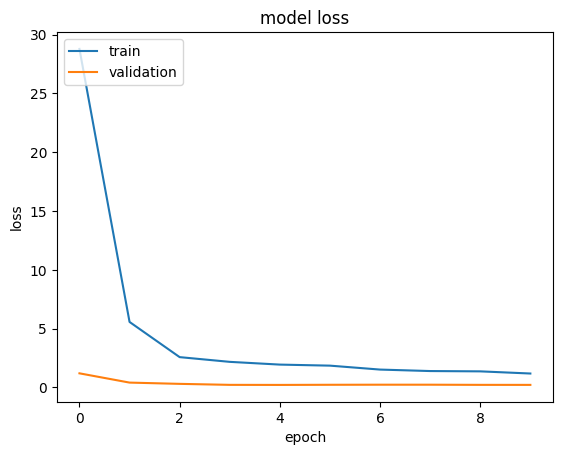

In [129]:
# matplotlb for plotting loss for training and validation
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.plot(validaton_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


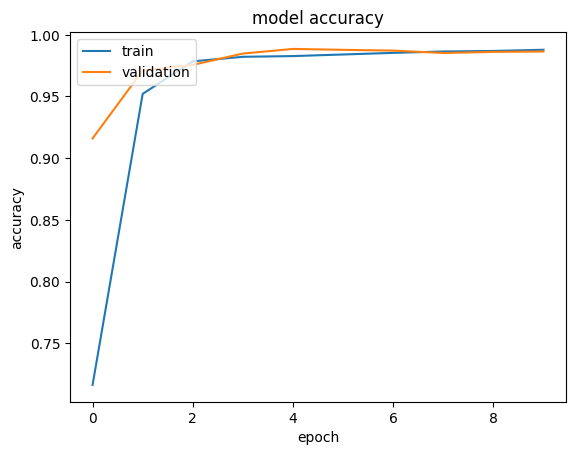

In [130]:
# matplotlb for plotting accuracy for training and validation
plt.plot(accuracy_list)
plt.plot(validaton_accuracy_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## Random Sentence Tagging

In [131]:

s = "we are coming from India"
model.load_state_dict(torch.load("modelFinal.pt"))

def genSentence(model,wordFreq,sentence):
    sentence = sentence.lower()
    sentence = sentence.split(" ")
    word_indice = []
    for s in sentence:
        if s not in wordFreq or wordFreq[s]<=2:
            word_indice.append(wordToIdx['<UNK>'])
        else:
            word_indice.append(wordToIdx[s])
    wordTen = torch.LongTensor(word_indice).to(device)
    wordTen = wordTen.view(1,-1)
    # predict the tag
    with torch.no_grad():
        model.eval()
        output = model(wordTen)
        _, predicted = torch.max(output, 2)
        # print(predicted.shape)
        for i in range(len(predicted[0])):
            print(sentence[i], idxToTag[predicted[0][i].item()])


genSentence(model,wordFreq,s)



we PRON
are AUX
coming VERB
from ADP
india <UNK>
